# Notebook to generate attention distribution plots.

This notebook requires the processed behavior data for the triangle task, saved
in `../../../cache/behavior/triangle.csv`. This can be downloaded from the OSF
repo or can be generated by running the script
`../../../behavior_processing/run_cache_data.py`.

This notebook also requires the modeling results data, saved in
`../../cache/phys_modeling_logs/main`. This can be downloaded from the OSF
repo or can be generated by training the models yourself.

In [1]:
"""Imports."""

import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../behavior_processing')
import load_triangle_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [8]:
"""Specify which model to analyze."""

# MODEL_NAME = "triangle_gain"
# MODEL_NAME = "triangle_switching"
MODEL_NAME = "triangle_slot_partition"

if MODEL_NAME == "triangle_gain":
    MODEL_TITLE = "Gain"
elif MODEL_NAME == "triangle_switching":
    MODEL_TITLE = "Switching"
elif MODEL_NAME == "triangle_slot_partition":
    MODEL_TITLE = "Slot"

In [9]:
"""Load results."""

np.random.seed(0)  # For reproducibility
MODEL_CACHE_DIR = Path("../../cache/modeling/main") / MODEL_NAME

# Behavior
df = load_triangle_data.load_data()
for i in range(3):
    df[f"attention_{i}"] = np.nan
df["num_neurons"] = np.nan

def get_attention(subject, session, seed):
    model_dir = MODEL_CACHE_DIR / subject / session / seed
    attention = np.load(model_dir / "stop_step" / "model_cache" / "attention.npy")
    trial_num = np.load(model_dir / "stop_step" / "dataset_cache" / "trial_num.npy")
    train_metrics = json.load(open(model_dir / "train_metrics.json"))
    num_neurons = train_metrics[0]["num_neurons"]
    
    # Get behavior corresponding to this session and seed
    df_tmp = df[
        (df["subject"] == subject) &
        (df["session"] == session) &
        (df["trial_num"].isin(trial_num))
    ]
    if len(df_tmp) != len(trial_num):
        raise ValueError("Mismatched number of trials")
    if not np.array_equal(df_tmp["trial_num"].values, trial_num):
        raise ValueError("Mismatched trial numbers")
    indices = df_tmp.index    

    return indices, attention, num_neurons

for subject_dir in MODEL_CACHE_DIR.iterdir():
    subject = subject_dir.name
    if subject.startswith("."):
        continue
    for session_dir in subject_dir.iterdir():
        session = session_dir.name
        if session.startswith("."):
            continue
        attention_per_seed = []
        for seed_dir in session_dir.iterdir():
            seed = seed_dir.name
            if seed.startswith("."):
                continue
            new_indices, attention, num_neurons = get_attention(subject, session, seed)
            if attention is None:
                continue
            if MODEL_NAME == "triangle_slot_partition":
                attention = attention[:, 0]
            attention_per_seed.append(attention)
            indices = new_indices
        if len(attention_per_seed) == 0:
            continue
        mean_attention = np.mean(attention_per_seed, axis=0)
        df.loc[indices, "attention_0"] = mean_attention[:, 0]
        df.loc[indices, "attention_1"] = mean_attention[:, 1]
        df.loc[indices, "attention_2"] = mean_attention[:, 2]
        df.loc[indices, "num_neurons"] = num_neurons
        
df = df[df.completed]
df = df[["subject", "session", "object_0_location", "object_1_location", "object_2_location", "attention_0", "attention_1", "attention_2", "num_neurons", "num_objects"]]

# Compute attention for each object location
df["attn_loc_0"] = np.nan
df["attn_loc_1"] = np.nan
df["attn_loc_2"] = np.nan
for i, row in df.iterrows():
    for obj_id in range(3):
        obj_loc = row[f"object_{obj_id}_location"]
        if np.isnan(obj_loc):
            continue
        obj_loc = int(obj_loc)
        obj_attn = row[f"attention_{obj_id}"]
        df.at[i, f"attn_loc_{obj_loc}"] = obj_attn
        
df = df[["subject", "session", "attn_loc_0", "attn_loc_1", "attn_loc_2", "num_neurons", "num_objects"]]

# Melt from wide to long format
df_melted = df.melt(
    id_vars=["subject", "session", "num_neurons", "num_objects"],
    value_vars=["attn_loc_0", "attn_loc_1", "attn_loc_2"],
    var_name="object_location",
    value_name="attention"
)
df_melted["object_location"] = df_melted["object_location"].str.replace("attn_loc_", "").astype(int)

/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vec

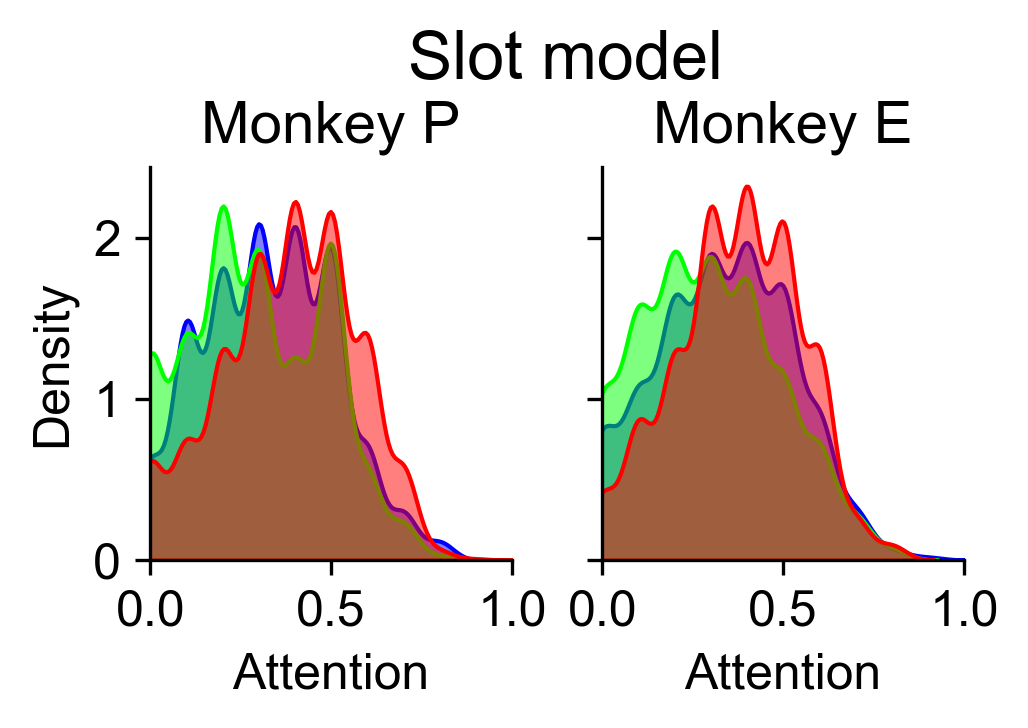

In [10]:
"""Plot."""

_PALLETE = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (0, 0, 1),
}

fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.7), sharey=True, gridspec_kw={'wspace': 0.25})
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    sns.despine(ax=ax)
    df_num_objects = df_melted[
        (df_melted["num_objects"] == 3)
        & (df_melted["subject"] == subject)
        & (df_melted["num_neurons"] > 100)
    ]
    sns.kdeplot(
        data=df_num_objects,
        x="attention",
        hue="object_location",
        ax=ax,
        fill=True,
        alpha=0.5,
        common_norm=False,
        palette=_PALLETE,
        legend=False,
    )
    ax.set_title(f"Monkey {subject[0]}")
    ax.set_xlabel("Attention")
    ax.set_ylabel("Density")
    
    if MODEL_NAME == "triangle_gain":
        ax.set_xlim(0, 1)
    elif MODEL_NAME == "triangle_switching":
        ax.set_xlim(0, 1)
    elif MODEL_NAME == "triangle_slot_partition":
        ax.set_xlim(0, 1)
        
# Save figure
fig.suptitle(f"{MODEL_TITLE} model", x=0.52, y=1.15, fontsize=16)
fig.tight_layout()
fig.savefig(f"./plots/attention_density_{MODEL_NAME}.pdf", bbox_inches="tight", pad_inches=0.01)

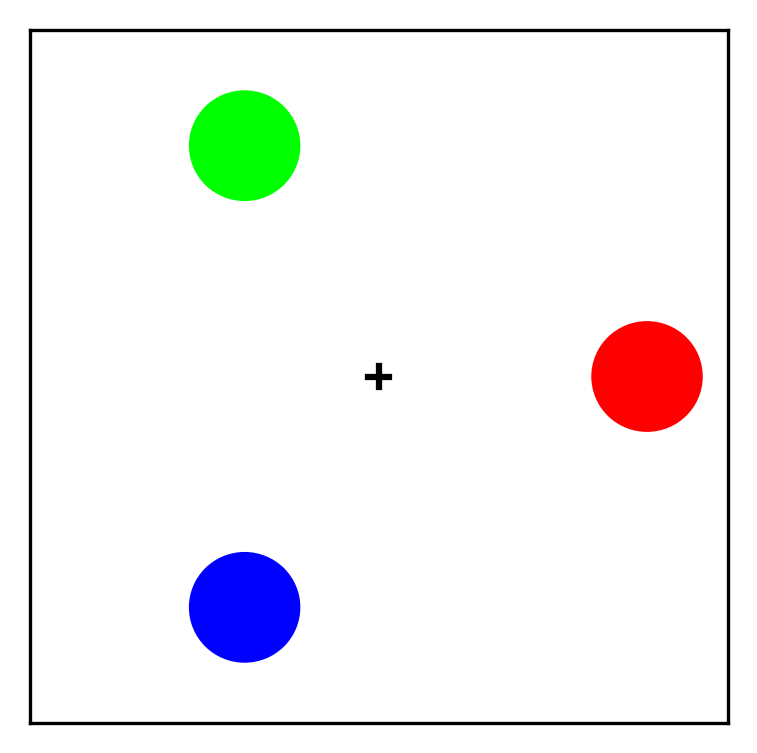

In [75]:

# Plot triangle with same colors
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
ax.set_xticks([])
ax.set_yticks([])
for i in range(3):
    color = _PALLETE[i]
    theta = 2 * np.pi / 3 * i
    x = np.cos(theta)
    y = np.sin(theta)
    circle = plt.Circle((x, y), 0.2, color=color, fill=True)
    ax.add_artist(circle)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)

# Make fixation cross
ax.plot([0, 0], [-0.04, 0.04], color="black")
ax.plot([-0.04, 0.04], [0, 0], color="black")

# Save figure
fig.savefig(f"plots/attention_density_colorscheme.pdf", bbox_inches="tight", pad_inches=0.01)